   *«Никто не ждёт тебя так сильно, как таксисты в аэропортах.»*

   -- Народный афоризм

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Смелая-гипотеза" data-toc-modified-id="Смелая-гипотеза-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Смелая гипотеза</a></span><ul class="toc-item"><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></li><li><span><a href="#Никакая-гипотеза" data-toc-modified-id="Никакая-гипотеза-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Никакая гипотеза</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Дерево-решений" data-toc-modified-id="Дерево-решений-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Дерево решений</a></span></li><li><span><a href="#Итог" data-toc-modified-id="Итог-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Итог</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Построим модель для такого предсказания.

## Подготовка

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn import tree
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
data = pd.read_csv('/datasets/taxi.csv')

Посмотрим на загружаемые данные.

In [3]:
data.head(10)

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
5,2018-03-01 00:50:00,21
6,2018-03-01 01:00:00,7
7,2018-03-01 01:10:00,5
8,2018-03-01 01:20:00,17
9,2018-03-01 01:30:00,12


Переведём информацию о дате в более удобный формат и установим нужный столбец в индекс.

In [4]:
data['datetime'] = pd.to_datetime(
    data['datetime'], format='%Y-%m-%d %H:%M:%S'
)

data = data.set_index('datetime')

Данные расположены в хронологическом порятке.

In [5]:
data.index.is_monotonic

True

In [6]:
data1h = data.resample('1H').sum()

Кроме того можем посмотреть на полную информацию по данным.

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


## Анализ

Разделим временные данные предоставляемые графиком на сезонные, тред и шум. Сезонная составляющая графика демонстрирует некоторую зависимость от времени с периодом в один день.

<AxesSubplot:xlabel='datetime'>

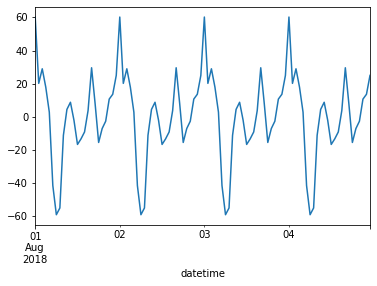

In [8]:
de1h = seasonal_decompose(data1h)
#de1h.trend.plot()
de1h.seasonal['2018-08-01':'2018-08-04'].plot()
#de1h.resid.plot()

В то время как график тренда похож на динамику изменения среднего за сутки (по скользящему среднему).

<AxesSubplot:xlabel='datetime'>

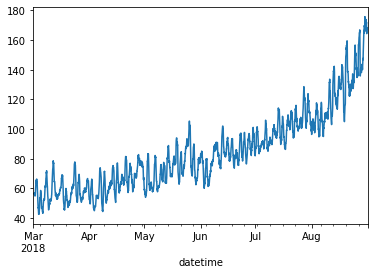

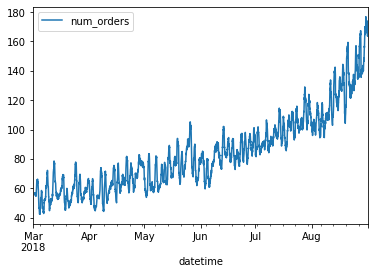

In [9]:
de1h = seasonal_decompose(data1h)
de1h.trend.plot()
#de1h.seasonal['2018-08-01':'2018-08-04'].plot()
#de1h.resid.plot()
data1h.rolling(24).mean().plot()

Кроме того, можно показать периодическую структуру сезонности на больших масштабах, это позволит нам сильнее убедиться в её периодической структуре. Месяц сезонности выглядит так:

<AxesSubplot:xlabel='datetime'>

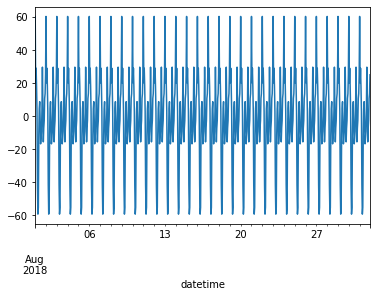

In [10]:
de1h = seasonal_decompose(data1h)
#de1h.trend.plot()
de1h.seasonal['2018-08':'2018-09'].plot()
#de1h.resid.plot()

При этом неделя сезонности выглядит так:

<AxesSubplot:xlabel='datetime'>

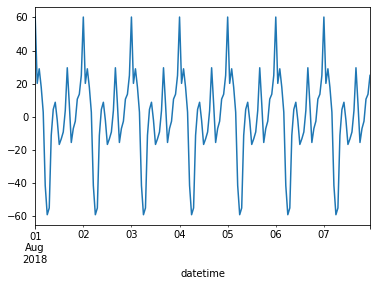

In [11]:
de1h = seasonal_decompose(data1h)
#de1h.trend.plot()
de1h.seasonal['2018-08-01':'2018-08-07'].plot()
#de1h.resid.plot()

## Смелая гипотеза

Предположим, что для того чтобы предсказать количество заказов такси на следующий день в каждый час нужно взять среднее количество заказов по часам за предыдущий день и прибавить к нему сезонную составляющую за соответсвующий час. Проверим данную смелую гипотезу, подготовив соответсвующие выборки и узнав среднеквадратичную ошибку.

### Обучение

Предскажем следующее значение среднего количества заказов за день по предыдущему для тренировочной выборки.

In [12]:
#trend = de1h.trend.dropna()
#sesonal = de1h.seasonal[de1h.trend.dropna().index.min():de1h.trend.dropna().index.max()]
trend = data.resample('1D').mean().reset_index(drop=True)
sesonal_min = de1h.seasonal['2018-08-01'].reset_index(drop=True) # насколько я понимаю, нас устроит любой день

train, test = train_test_split(trend, shuffle=False, test_size=0.1)
# train: 2018-03-02 -- 2018-08-12
# test: 2018-08-13 -- 2018-08-31

pred = train.shift()

pred = pred.iloc[1:].reset_index(drop=True)
train = train.iloc[1:].reset_index(drop=True)
print("RMSE:", mean_squared_error(pred, train) ** 0.5)

RMSE: 1.5960015071264109


Добавим к среднему значению сезонную составляющую.

In [13]:
def to24_plusperiod(a,p):
    b = []
    for i in a['num_orders']:
        for j in range(0,24):
            b.append(i + p[j])
    q = { # тут этот промежуток времени как-нибудь автоматически бы вычислять
        'datetime' : data.resample('1H').mean()['2018-03-02':'2018-08-12'].reset_index()['datetime'],
        'num_orders' : b
        }
    return pd.DataFrame(q).set_index('datetime')


pred24 = to24_plusperiod(pred,sesonal_min)
train24 = to24_plusperiod(train,sesonal_min)
print("RMSE:", mean_squared_error(pred24, train24) ** 0.5)

RMSE: 1.5960015071264109


### Тестирование

Проделаем ту же процедуру с тестовой выборкой найдём среднее количество заказаов за день.

In [14]:
pred = test.shift()

pred.iloc[0] = train.tail(1) # есть в тренировочной выборке
pred = pred.reset_index(drop=True)
test = test.reset_index(drop=True)
print("RMSE:", mean_squared_error(pred, test) ** 0.5)

RMSE: 2.9819491940300513


Добавим к этим значениям сезонную составляющую.

In [15]:
def to24_plusperiod(a,p):
    b = []
    for i in a['num_orders']:
        for j in range(0,24):
            b.append(i + p[j])
    q = { # тут этот промежуток времени как-нибудь автоматически бы вычислять
        'datetime' : data.resample('1H').mean()['2018-08-13':'2018-08-31'].reset_index()['datetime'],
        'num_orders' : b
        }
    return pd.DataFrame(q).set_index('datetime')


pred24 = to24_plusperiod(pred,sesonal_min)
test24 = to24_plusperiod(test,sesonal_min)
print("RMSE:", mean_squared_error(pred24, test24) ** 0.5)

RMSE: 2.981949194030052


## Никакая гипотеза

Проверим среднеквадратичное отклонени при применении метода, описанного в смелой гипотезе, но без вычесления среднего по дням.

In [16]:
##trend = de1h.trend.dropna()
##sesonal = de1h.seasonal[de1h.trend.dropna().index.min():de1h.trend.dropna().index.max()]
train, test = train_test_split(data1h, shuffle=False, test_size=0.1)

pred = train.shift()

pred = pred.iloc[1:].reset_index(drop=True)
train = train.iloc[1:].reset_index(drop=True)
print("RMSE:", mean_squared_error(pred, train) ** 0.5)

RMSE: 36.1452484171318


Результат оставляет желать лучшего.

## Обучение моделей

Обучим ряд моделей, подготовив для них необходимые признаки. Найдём лучшую модель, узнав среднеквадратичную ошибку полученых на этапе обучения предсказаний.

### Линейная регрессия

Начнём с модели линейной регрессии.

In [17]:
def make_features(df, max_lag, rolling_mean_size):
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['roll'] = df['num_orders'].shift().rolling(rolling_mean_size).mean() 

rr = 48
data1ht = data1h
for (i,j) in [(i,j) for i in range(20,26) for j in range(1,8)]:
    print(i,j)
    make_features(data1ht, i, j)
    data1ht = data1ht.dropna()

    f = data1ht.drop('num_orders', axis=1)
    t = data1ht['num_orders']

    # разбиение признаков
    f_trn, f_vld, f_tst = \
              np.split(f, # насколько я могу понять тут не нужно перемешивать
                       [int(.8*len(f)), int(.9*len(f))])

    # разбиение целевого признака
    t_trn, t_vld, t_tst = \
              np.split(t, # насколько я могу понять тут не нужно перемешивать
                       [int(.8*len(t)), int(.9*len(t))])

    model = LinearRegression()
    model.fit(f_trn, t_trn)
    pred = model.predict(f_vld)
    
    r = mean_squared_error(pred,t_vld) ** 0.5
    if (r < rr):
        rr = r
        mm = model
        iir = i
        jjr = j

print("best\nRMSE: " + str(rr) + "\ni: " + str(i) + "\nj: " + str(j))

20 1
20 2
20 3


/tmp/ipykernel_123/1182562633.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'] = df.index.month
/tmp/ipykernel_123/1182562633.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['day'] = df.index.day
/tmp/ipykernel_123/1182562633.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

20 4
20 5
20 6
20 7
21 1
21 2
21 3
21 4
21 5
21 6
21 7
22 1
22 2
22 3
22 4
22 5
22 6
22 7
23 1
23 2
23 3
23 4
23 5
23 6
23 7
24 1
24 2
24 3
24 4
24 5
24 6
24 7
25 1
25 2
25 3
25 4
25 5
25 6
25 7
best
RMSE: 36.08091780964268
i: 25
j: 7


Проверим модель на тестовых данных. Выведем название модели.

In [18]:
data1ht = data1h
make_features(data1ht, iir, jjr)
data1ht = data1ht.dropna()

f = data1ht.drop('num_orders', axis=1)
t = data1ht['num_orders']

# разбиение признаков
f_trn, f_vld, f_tst = \
              np.split(f, # насколько я могу понять тут не нужно перемешивать
                       [int(.8*len(f)), int(.9*len(f))])

# разбиение целевого признака
t_trn, t_vld, t_tst = \
              np.split(t, # насколько я могу понять тут не нужно перемешивать
                       [int(.8*len(t)), int(.9*len(t))])

mm.fit(f_trn, t_trn)
pred = mm.predict(f_tst)

bmlr = mm 
print("Название модели:", str(bmlr))
print("RMSE:", mean_squared_error(pred,t_tst) ** 0.5)

Название модели: LinearRegression()
RMSE: 46.17282778300395


### Дерево решений

In [19]:
def make_features(df, max_lag, rolling_mean_size):
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['roll'] = df['num_orders'].shift().rolling(rolling_mean_size).mean() 

rr = 100000
data1ht = data1h
for (i,j,k,p) in [(i,j,k,p) for i in range(20,26) for j in range(1,4) for k in range(1,4) for p in range(1,4)]:
    print(i,j,k,p)
    make_features(data1ht, i, j)
    data1ht = data1ht.dropna()

    f = data1ht.drop('num_orders', axis=1)
    t = data1ht['num_orders']

    # разбиение признаков
    f_trn, f_vld, f_tst = \
              np.split(f, # насколько я могу понять тут не нужно перемешивать
                       [int(.8*len(f)), int(.9*len(f))])

    # разбиение целевого признака
    t_trn, t_vld, t_tst = \
              np.split(t, # насколько я могу понять тут не нужно перемешивать
                       [int(.8*len(t)), int(.9*len(t))])

    model = tree.DecisionTreeRegressor(max_depth=k, min_samples_leaf=p) # ПОСМОТРИ СЮДА, Я ТЕБЯ ОЧЕНЬ ПРОШУ
    model.fit(f_trn, t_trn)
    pred = model.predict(f_vld)
    
    r = mean_squared_error(pred,t_vld) ** 0.5
    if (r < rr):
        rr = r
        mm = model
        iid = i
        jjd = j

print("best\nRMSE: " + str(rr) + "\ni: " + str(i) + "\nj: " + str(j))

20 1 1 1
20 1 1 2
20 1 1 3
20 1 2 1
20 1 2 2
20 1 2 3
20 1 3 1
20 1 3 2
20 1 3 3
20 2 1 1


/tmp/ipykernel_123/1757542226.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'] = df.index.month
/tmp/ipykernel_123/1757542226.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['day'] = df.index.day
/tmp/ipykernel_123/1757542226.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

20 2 1 2
20 2 1 3
20 2 2 1
20 2 2 2
20 2 2 3
20 2 3 1
20 2 3 2
20 2 3 3
20 3 1 1
20 3 1 2
20 3 1 3
20 3 2 1
20 3 2 2
20 3 2 3
20 3 3 1
20 3 3 2
20 3 3 3
21 1 1 1
21 1 1 2
21 1 1 3
21 1 2 1
21 1 2 2
21 1 2 3
21 1 3 1
21 1 3 2
21 1 3 3
21 2 1 1
21 2 1 2
21 2 1 3
21 2 2 1
21 2 2 2
21 2 2 3
21 2 3 1
21 2 3 2
21 2 3 3
21 3 1 1
21 3 1 2
21 3 1 3
21 3 2 1
21 3 2 2
21 3 2 3
21 3 3 1
21 3 3 2
21 3 3 3
22 1 1 1
22 1 1 2
22 1 1 3
22 1 2 1
22 1 2 2
22 1 2 3
22 1 3 1
22 1 3 2
22 1 3 3
22 2 1 1
22 2 1 2
22 2 1 3
22 2 2 1
22 2 2 2
22 2 2 3
22 2 3 1
22 2 3 2
22 2 3 3
22 3 1 1
22 3 1 2
22 3 1 3
22 3 2 1
22 3 2 2
22 3 2 3
22 3 3 1
22 3 3 2
22 3 3 3
23 1 1 1
23 1 1 2
23 1 1 3
23 1 2 1
23 1 2 2
23 1 2 3
23 1 3 1
23 1 3 2
23 1 3 3
23 2 1 1
23 2 1 2
23 2 1 3
23 2 2 1
23 2 2 2
23 2 2 3
23 2 3 1
23 2 3 2
23 2 3 3
23 3 1 1
23 3 1 2
23 3 1 3
23 3 2 1
23 3 2 2
23 3 2 3
23 3 3 1
23 3 3 2
23 3 3 3
24 1 1 1
24 1 1 2
24 1 1 3
24 1 2 1
24 1 2 2
24 1 2 3
24 1 3 1
24 1 3 2
24 1 3 3
24 2 1 1
24 2 1 2
24 2 1 3
24 2 2 1
2

Проверим модель на тестовых данных. Выведем название модели.

In [20]:
data1ht = data1h
make_features(data1ht, iid, jjd)
data1ht = data1ht.dropna()

f = data1ht.drop('num_orders', axis=1)
t = data1ht['num_orders']

# разбиение признаков
f_trn, f_vld, f_tst = \
              np.split(f, # насколько я могу понять тут не нужно перемешивать
                       [int(.8*len(f)), int(.9*len(f))])

# разбиение целевого признака
t_trn, t_vld, t_tst = \
              np.split(t, # насколько я могу понять тут не нужно перемешивать
                       [int(.8*len(t)), int(.9*len(t))])

mm.fit(f_trn, t_trn)
pred = mm.predict(f_tst)

bmtr = mm 
print("Название модели:", str(bmtr))
print("RMSE:", mean_squared_error(pred,t_tst) ** 0.5)

Название модели: DecisionTreeRegressor(max_depth=3)
RMSE: 63.4866267854205


### Итог

Полученные значения минимального RMSE для линейной регрессии и дерева решений довольно близки, но значение для линейной регрессии меньше, поэтому для тестирования на следующем этапе мы возьмём именно эту модель.

In [21]:
data1ht = data1h
make_features(data1ht, iir, jjr)
data1ht = data1ht.dropna()

f = data1ht.drop('num_orders', axis=1)
t = data1ht['num_orders']

# разбиение признаков
f_trn, f_vld, f_tst = \
              np.split(f, # насколько я могу понять тут не нужно перемешивать
                       [int(.8*len(f)), int(.9*len(f))])

# разбиение целевого признака
t_trn, t_vld, t_tst = \
              np.split(t, # насколько я могу понять тут не нужно перемешивать
                       [int(.8*len(t)), int(.9*len(t))])

bmlr.fit(f_trn, t_trn)
pred = bmlr.predict(f_tst)

print("Название модели:", str(bmlr))
print("RMSE:", mean_squared_error(pred,t_tst) ** 0.5)

Название модели: LinearRegression()
RMSE: 46.17282778300395


### Вывод

В данных разделах были построены и проанализированы модели линейной регрессии и дерева решений, в ходе анализа были перебраны различные параметры таких моделей. Была выбрана лучшая с точки зрения наименьшей среднеквадратичной ошибки модель, которая была проверена на тестовых данных. Было получено минимальное среднеквадратичное отклонение соответсвующее условием поставленной задачи.

## Вывод

В данной работе была построена модель для предсказания количества заказов такси в аэропортах (Смелая гипотеза). Получено низкое значение квадрата среднеквадратичной ошибки говорит о высокой точности такой модели. Следует также сказать, что точность такой модели будет тем выше, чем ближе промежуток времени, который необходимо предсказать, к известным нам данным.